# ANN Final Portfolio - Lilly Abraham(5123768)

## Task 1 - Sudoku Image Reading

### Approach 1 - CNN Model with MNIST dataset

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np
from torch.utils.data import TensorDataset
import pandas as pd

#### Data Preprocessing of test images

In [2]:
test_images = np.load('./Task1/test/imgs.npy')

test_images_tensor = torch.Tensor(test_images)
test_dataset = TensorDataset(test_images_tensor)  
print('Test images shape',test_images.shape)

transform = transforms.Compose([   
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.ToTensor(),  
])
test_dataset.transform = transform

Test images shape (10000, 252, 252)


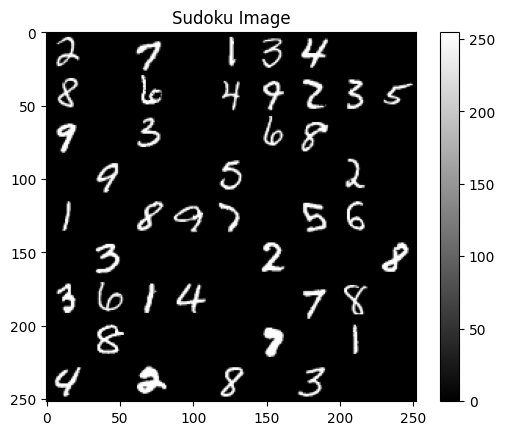

In [3]:
image = test_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Image')
plt.colorbar()  
plt.show()

#### CNN Model training with MNIST dataset

In [4]:
def _get_conv_output_size(input_size, out_channels, model):
    batch_size = 1
    input_tensor = torch.autograd.Variable(torch.rand(batch_size, *input_size))
    output_feat = model.features(input_tensor)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

In [5]:
class MNIST(nn.Module):
    def __init__(self, out_channels):
        super(MNIST, self).__init__()

        conv_layers = []
        num_conv_layers = len(out_channels)

        for i in range(num_conv_layers):
            if i == 0:
                conv_layers.append(nn.Conv2d(1, out_channels[i], kernel_size=3, padding=1))
            else:
                conv_layers.append(nn.Conv2d(out_channels[i-1], out_channels[i], kernel_size=3, padding=1))

            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.features = nn.Sequential(*conv_layers)
        self.fc1 = nn.Linear(_get_conv_output_size((1, 28, 28), out_channels, self), 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [6]:
def mnist_train(out_channels, num_epochs, batch_size, learning_rate, device, plots):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    #Downloading MNIST dataset from pytorch
    train_dataset = datasets.MNIST(root='./mnist/train', train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root='./mnist/test', train=False, download=False, transform=transform)
    
    indices_to_keep = [i for i, (image, label) in enumerate(train_dataset)] # if label != 0 because filled sudokus - some digits are incorrectly getting classified as 0
    filtered_train_dataset = torch.utils.data.Subset(train_dataset, indices_to_keep)

    train_loader = torch.utils.data.DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    mnist_model = MNIST(out_channels)
    mnist_model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mnist_model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        mnist_model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = mnist_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        accuracy = 100 * (correct / total)
        accuracies.append(accuracy)

        mnist_model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = mnist_model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}")

    if plots:
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    return mnist_model, (train_losses, test_losses, accuracies)

Epoch [1/10], Train Loss: 0.1282, Validation Loss: 0.0643, Accuracy: 96.04
Epoch [2/10], Train Loss: 0.0446, Validation Loss: 0.0343, Accuracy: 98.58
Epoch [3/10], Train Loss: 0.0341, Validation Loss: 0.0293, Accuracy: 98.90
Epoch [4/10], Train Loss: 0.0255, Validation Loss: 0.0347, Accuracy: 99.18
Epoch [5/10], Train Loss: 0.0217, Validation Loss: 0.0404, Accuracy: 99.31
Epoch [6/10], Train Loss: 0.0185, Validation Loss: 0.0366, Accuracy: 99.41
Epoch [7/10], Train Loss: 0.0175, Validation Loss: 0.0458, Accuracy: 99.49
Epoch [8/10], Train Loss: 0.0157, Validation Loss: 0.0595, Accuracy: 99.49
Epoch [9/10], Train Loss: 0.0134, Validation Loss: 0.0667, Accuracy: 99.57
Epoch [10/10], Train Loss: 0.0140, Validation Loss: 0.0369, Accuracy: 99.55


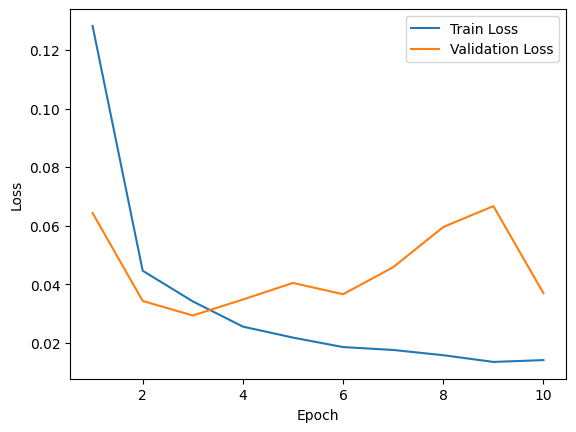

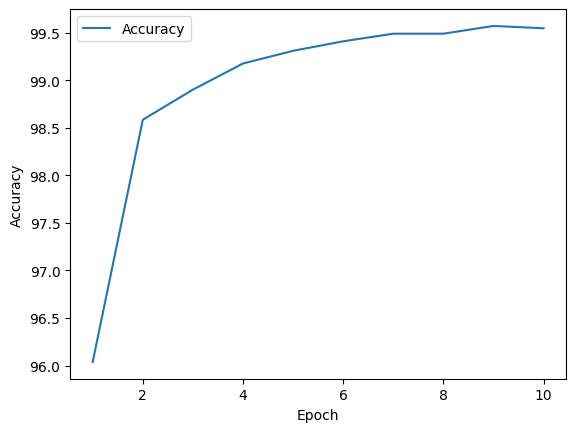

MNIST(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
out_channels = [16, 32, 128] 
num_epochs = 10
batch_size = 34
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plots = True 

mnist_model, (train_losses, test_losses, accuracies) = mnist_train(out_channels, num_epochs, batch_size, learning_rate, device, plots)
print(mnist_model)

#### Model Predictions and Submission File formatting

In [16]:
def mnist_apply(model, images):

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    images = images.to(device)
    
    if torch.sum(images) == 0: # Return 0 incase pixel values are 0
        return 0  

    images = images.unsqueeze(0)
    # images = torch.nn.functional.interpolate(images.unsqueeze(0), size=(28, 28), mode='nearest').squeeze(0)
        
    with torch.no_grad():
        output = model(images.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    
    return predicted.item()


In [17]:
sudoku_grid_size=81
x=y=9

sudoku_tensor = torch.zeros(10000, 9, 9)
partial_sudokus=np.empty(10000, dtype=object)

In [18]:
image=0
for sudoku_tuple in test_dataset:
    sudoku_grid = sudoku_tuple[0]  
    cell=0
    partial_sudokus[image] = []
    for cell in range(sudoku_grid_size):
        cell_digit = sudoku_grid[
                            (cell // 9) * 28: (cell // 9 + 1) * 28,
                            (cell % 9) * 28: (cell % 9 + 1) * 28
                        ]
        digit_value = mnist_apply(mnist_model, cell_digit)
        x, y = divmod(cell, 9)
        sudoku_tensor[image, x, y] = digit_value
        partial_sudokus[image].append(digit_value)
        
        cell+=1
    image+=1
    
sudoku = sudoku_tensor.numpy()
sudoku.shape

(10000, 9, 9)

In [11]:
df = pd.DataFrame(columns=['id', 'value'])
df = df.reset_index(drop=True)

rows = []

for image in range(sudoku.shape[0]):
    for x in range(sudoku.shape[1]):
        for y in range(sudoku.shape[2]):
            cell_id = f'{image}_{x}{y}'
            cell_value = sudoku[image][x][y]
            rows.append({'id': cell_id, 'value': cell_value})

df = pd.DataFrame(rows)
df['value'] = df['value'].astype(int)
df

,id,value
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


In [12]:
df.to_csv('Submission_Task1_CNN.csv', index=False)

#### Summary
* Loaded the mnist handwritten digits as is mentioned in [paper](https://arxiv.org/pdf/2106.03121v1.pdf)  to predict each cell of the sudoku grid
* Excluded 0 labels as this incorrectly classifies unintelligible digits
* Trained CNN model to make predictions on each cell of test images checking if no pixels in test images, then hardcode the label as 0 
* Loaded a 3d tensor object so that image id, x and postions and its values are stored in each entry to easily extract as is in the submissin file format

##### For Task 2 - reading the values of both partial and fully filled sudoku grid with the mnist model predictons into pandas dataframes

In [13]:
data = np.array([np.array(partial_sudoku) for partial_sudoku in partial_sudokus])
df = pd.DataFrame(data)
df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,2,0,7,0,1,3,4,0,0,8,...,0,4,0,2,0,8,0,3,0,0
1,0,0,2,0,8,0,0,4,9,0,...,0,0,8,6,0,7,0,8,0,0
2,0,0,0,0,4,6,3,0,0,8,...,5,0,9,5,0,6,0,0,7,0
3,0,0,4,5,0,0,0,0,6,8,...,7,0,7,3,4,0,0,2,0,0
4,0,0,9,0,0,3,0,0,0,0,...,8,4,0,0,8,4,7,9,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,0,1,0,0,2,7,8,0,0,...,9,0,1,2,0,0,8,5,0,0
9996,0,0,0,0,7,2,6,0,9,0,...,0,5,0,0,0,2,0,0,0,0
9997,1,8,7,5,0,0,0,0,3,0,...,0,3,6,9,0,0,0,0,4,1
9998,7,0,0,4,1,0,0,9,8,0,...,0,0,7,2,0,0,3,4,0,0


In [14]:
# Save the DataFrame to a CSV file
#df.to_csv('test_sudokus.csv', index=False, header=True)

### Approach 2 - MLP Model with given task dataset

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [16]:
train_images = np.load('./Task1/train/imgs-001.npy')
test_images = np.load('./Task1/test/imgs.npy')

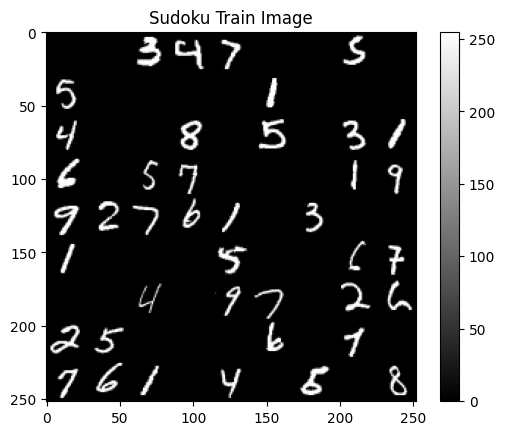

In [183]:
image = train_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Train Image')
plt.colorbar() 
plt.show()

#### Data Preprocessing of both training and test images

In [18]:
new_size = (128, 128)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(new_size),
    transforms.ToTensor(),  
])

resized_train_images = torch.stack([transform(image) for image in train_images])
resized_test_images = torch.stack([transform(image) for image in test_images])

normalized_resized_train_images = resized_train_images / 255.0
normalized_resized_test_images = resized_test_images / 255.0

normalized_resized_train_images = normalized_resized_train_images.squeeze(dim=1)
normalized_resized_test_images = normalized_resized_test_images.squeeze(dim=1)

print('Train image shape',normalized_resized_train_images.shape)
print('Test image shape', normalized_resized_test_images.shape)

Train image shape torch.Size([50000, 128, 128])
Test image shape torch.Size([10000, 128, 128])


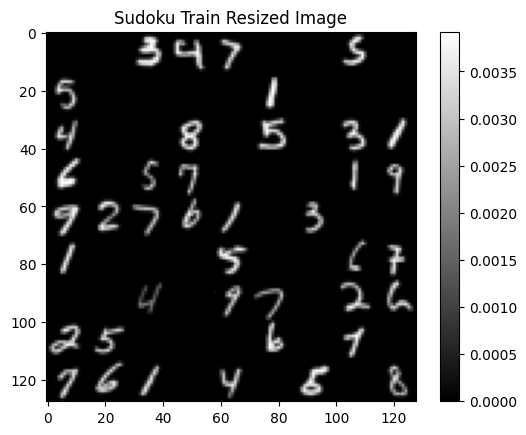

In [182]:
image = normalized_resized_train_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Train Resized Image')
plt.colorbar()  
plt.show()

In [20]:
def cell_extraction(images, new_size=(14, 14)):
    num_images = images.shape[0]
    processed_images = np.zeros((num_images * 81, new_size[0], new_size[1]))

    for idx in range(num_images):
        for row in range(9):
            for col in range(9):
                cell = images[idx, row*new_size[0]:(row+1)*new_size[0], col*new_size[1]:(col+1)*new_size[1]]
                processed_images[idx * 81 + row * 9 + col]  = cell

    return processed_images

normalized_resized_train_images_np = normalized_resized_train_images.cpu().numpy()

train_images_processed = cell_extraction(normalized_resized_train_images_np)
print('Train preprocessed image shape',train_images_processed.shape)
test_images_processed = cell_extraction(normalized_resized_test_images.cpu().numpy())
print('Test preprocessed image shape',test_images_processed.shape)

Train preprocessed image shape (4050000, 14, 14)
Test preprocessed image shape (810000, 14, 14)


##### Handling labels of cells with missing digits

In [21]:
train_labels = np.load('./Task1/train/known_values_labels.npy')
print('Original labels')
train_labels #x, y, value

Original labels


array([[[0., 2., 3.],
        [0., 3., 4.],
        [0., 4., 7.],
        ...,
        [8., 4., 4.],
        [8., 6., 5.],
        [8., 8., 8.]],

       [[0., 0., 7.],
        [0., 1., 2.],
        [0., 5., 6.],
        ...,
        [8., 3., 2.],
        [8., 4., 3.],
        [8., 5., 4.]],

       [[0., 0., 7.],
        [0., 5., 8.],
        [0., 7., 6.],
        ...,
        [8., 0., 5.],
        [8., 3., 3.],
        [8., 8., 8.]],

       ...,

       [[0., 1., 2.],
        [0., 4., 1.],
        [0., 6., 8.],
        ...,
        [8., 2., 9.],
        [8., 3., 5.],
        [8., 6., 7.]],

       [[0., 0., 5.],
        [0., 2., 2.],
        [0., 3., 8.],
        ...,
        [8., 5., 3.],
        [8., 6., 5.],
        [8., 8., 7.]],

       [[0., 2., 4.],
        [0., 8., 5.],
        [1., 0., 2.],
        ...,
        [8., 4., 6.],
        [8., 5., 3.],
        [8., 6., 5.]]])

In [22]:
empty_train_labels = np.zeros((1, 81, 3))
x_values, y_values = np.indices((9, 9))
empty_train_labels[:, :, 0] = x_values.flatten()
empty_train_labels[:, :, 1] = y_values.flatten()

In [23]:
appended_labels = np.zeros((train_labels.shape[0], 81, 3))

for i in range(train_labels.shape[0]):
    puzzle_labels = train_labels[i]
    puzzle_indices = puzzle_labels[:, :2].astype(int)
    all_indices = np.arange(81)
    missing_indices = np.setdiff1d(all_indices, np.ravel_multi_index(puzzle_indices.T, (9, 9)), assume_unique=True)
    missing_indices = missing_indices[missing_indices < 81]
    appended_labels[i, :puzzle_labels.shape[0], :] = puzzle_labels
    appended_labels[i, puzzle_labels.shape[0]:puzzle_labels.shape[0]+len(missing_indices), :] = empty_train_labels[0, missing_indices, :]
    sorted_indices = np.lexsort((appended_labels[i, :, 1], appended_labels[i, :, 0]))
    appended_labels[i] = appended_labels[i, sorted_indices]

In [24]:
modified_labels = np.array(appended_labels)
print('Complete labels')
modified_labels

Complete labels


array([[[0., 0., 0.],
        [0., 1., 0.],
        [0., 2., 3.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 8.]],

       [[0., 0., 7.],
        [0., 1., 2.],
        [0., 2., 0.],
        ...,
        [8., 6., 0.],
        [8., 7., 0.],
        [8., 8., 0.]],

       [[0., 0., 7.],
        [0., 1., 0.],
        [0., 2., 0.],
        ...,
        [8., 6., 0.],
        [8., 7., 0.],
        [8., 8., 8.]],

       ...,

       [[0., 0., 0.],
        [0., 1., 2.],
        [0., 2., 0.],
        ...,
        [8., 6., 7.],
        [8., 7., 0.],
        [8., 8., 0.]],

       [[0., 0., 5.],
        [0., 1., 0.],
        [0., 2., 2.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 7.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 2., 4.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 0.]]])

##### Extracting each cell image and labels and vertically stacking to an array

In [25]:
def cell_label_extraction(labels):

    num_images = len(labels)
    new_labels = np.zeros((num_images * 81), dtype=int)

    for i, label in enumerate(labels):
        for cell in label:
            x, y, value = cell
            x, y, value = int(x), int(y), int(value)  
            if 0 <= x < 9 and 0 <= y < 9:  
                # Convert 2D coordinates to 1D index and set the value
                new_labels[i * 81 + x * 9 + y] = value
                
    return new_labels

train_labels_processed = cell_label_extraction(train_labels)

In [26]:
train_labels_processed = torch.tensor(train_labels_processed, dtype=torch.long)
train_images_processed = torch.tensor(train_images_processed, dtype=torch.float32)
test_images_processed = torch.tensor(test_images_processed, dtype=torch.float32)
train_images_processed=train_images_processed.unsqueeze(1)
test_images_processed=test_images_processed.unsqueeze(1)
print('Train labels shape:',train_labels_processed.shape)
print('Train images shape:',train_images_processed.shape)
print('Test labels shape:',test_images_processed.shape)

Train labels shape: torch.Size([4050000])
Train images shape: torch.Size([4050000, 1, 14, 14])
Test labels shape: torch.Size([810000, 1, 14, 14])


In [27]:
images = train_images_processed
labels = train_labels_processed

dataset = TensorDataset(images, labels)

#Split into train and validation datasets

total_size=len(dataset)
train_size = 40000*81  # 10000 images for validation and 40000 images for testing
val_size = total_size - train_size

train_dataset = TensorDataset(*dataset[:train_size])
val_dataset = TensorDataset(*dataset[train_size:])
test_dataset = TensorDataset(test_images_processed)
print('Size of training dataset', len(train_dataset))
print('Size of validation dataset', len(val_dataset))

Size of training dataset 3240000
Size of validation dataset 810000


#### MLP Model training

In [28]:
batch_size = 64  
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(14 * 14, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes from 0 to 9

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLPModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLPModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

Epoch 1: Train Loss: 0.4243, Train Accuracy: 0.8630, Validation Loss: 0.2673, Validation Accuracy: 0.9175
Epoch 2: Train Loss: 0.2157, Train Accuracy: 0.9351, Validation Loss: 0.1754, Validation Accuracy: 0.9472
Epoch 3: Train Loss: 0.1505, Train Accuracy: 0.9550, Validation Loss: 0.1320, Validation Accuracy: 0.9600
Epoch 4: Train Loss: 0.1199, Train Accuracy: 0.9639, Validation Loss: 0.1100, Validation Accuracy: 0.9666
Epoch 5: Train Loss: 0.1032, Train Accuracy: 0.9689, Validation Loss: 0.0973, Validation Accuracy: 0.9705


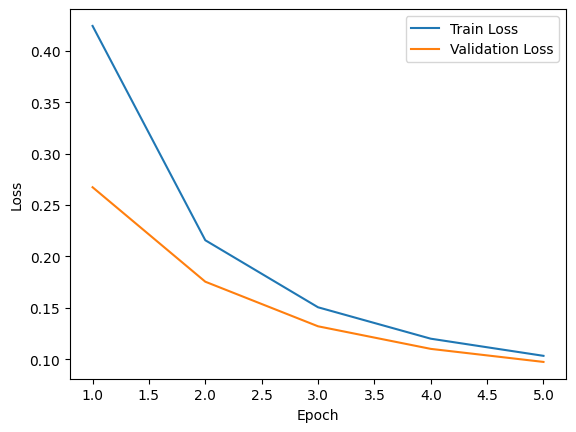

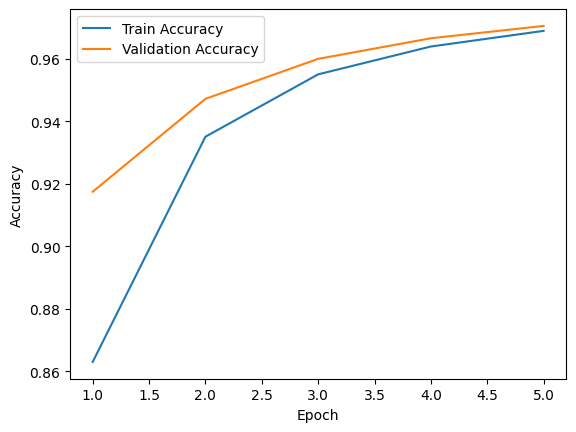

In [31]:
def train_model(model, train_loader, val_loader, epochs, plots):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        for batch_images, batch_labels in train_data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            train_correct += calculate_accuracy(outputs, batch_labels) * batch_labels.size(0)
            total_train += batch_labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_accuracy = train_correct / total_train
        train_acc_list.append(train_accuracy)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for batch_images, batch_labels in val_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                outputs = model(batch_images)
                val_loss += criterion(outputs, batch_labels).item()
                
                val_correct += calculate_accuracy(outputs, batch_labels.view(-1)) * batch_labels.size(0)
                total_val += batch_labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_accuracy = val_correct / total_val
        val_acc_list.append(val_accuracy)
        
        #scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}: '
                f'Train Loss: {avg_train_loss:.4f}, '
                f'Train Accuracy: {train_accuracy:.4f}, '
                f'Validation Loss: {avg_val_loss:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}')

    if plots:
        plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
            
train_model(model, train_data_loader, eval_data_loader, 5, plots = True)

##### MLP Model Predictions and Submission File Formatting

In [32]:
all_predictions = []
model.eval()

for batch in test_data_loader:
    images = batch[0] 
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)

    predicted_labels = torch.argmax(outputs, dim=1)
    #print(predicted_labels)
    all_predictions.append(predicted_labels)

all_predictions_tensor = torch.cat(all_predictions, dim=0)

all_predictions_np = all_predictions_tensor.cpu().numpy()
reshaped_predictions = np.reshape(all_predictions_np, (10000, 9, 9))
reshaped_predictions[0,:,:]

array([[2, 0, 7, 0, 1, 3, 4, 0, 0],
       [8, 0, 6, 0, 4, 9, 2, 3, 5],
       [9, 0, 3, 0, 0, 6, 8, 0, 0],
       [0, 9, 0, 0, 5, 0, 0, 2, 0],
       [1, 0, 8, 9, 7, 0, 5, 6, 0],
       [0, 3, 0, 0, 0, 2, 0, 0, 8],
       [3, 6, 1, 4, 0, 0, 7, 8, 0],
       [0, 8, 0, 0, 0, 9, 0, 1, 0],
       [4, 0, 2, 0, 8, 0, 3, 0, 0]])

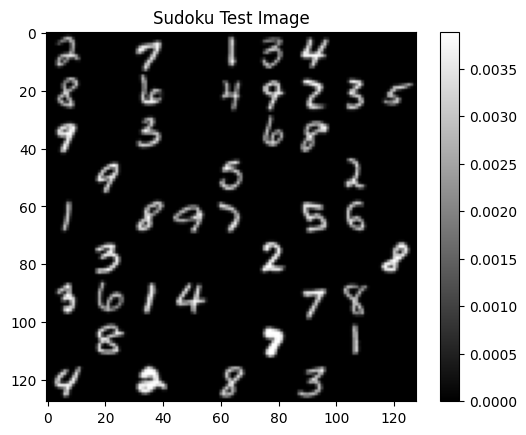

In [33]:
image = normalized_resized_test_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Test Image')
plt.colorbar()  
plt.show()

In [34]:
rows = []

for image in range(reshaped_predictions.shape[0]):
    for x in range(reshaped_predictions.shape[1]):
        for y in range(reshaped_predictions.shape[2]):
            cell_id = f'{image}_{x}{y}'
            cell_value = reshaped_predictions[image][x][y]
            rows.append({'id': cell_id, 'value': cell_value})
            
df = pd.DataFrame(rows)
df['value'] = df['value'].astype(int)
df.to_csv('Submission_Task1_MLP.csv', index=False)

#### Summary
* Normalised and resized given dataset images to handle kernel crashing
* Handled the training labels so as to impute 0 values for missing digits in the sudoku grid
* Flattened each cell of each sudoku grid into a tensor for both images and labels to train MLP moded
* Converted the flattened prediction labels of test images to a 3d tensor (9*9 grids) to easily extract the ids and its values to the submission file

| Task 1     | Model | Dataset | Accuracy(locally) | Accuracy(kaggle) |
|:--------:|:------:|:----------:|:---:|:----------:|
| Approach 1     | CNN  | MNIST   | 99.60% |  99.14 % |
| Approach 2     | MLP  | Task Dataset  | 99.68% | 99.56 %  |

## Task 2 - Sudoku Puzzle Solve

In [91]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

#### Data Preprocessing (Common in both approaches)

In [92]:
partial_sudokus = pd.read_csv('./partial_sudokus.csv')
filled_sudokus = pd.read_csv('./filled_sudokus.csv')
train_sudokus = pd.DataFrame({
    'partialsudokus': partial_sudokus.apply(lambda row: (''.join(map(str, row))), axis=1),
    'filledsudokus': filled_sudokus.apply(lambda row: (''.join(map(str, row))), axis=1)
})

train_sudokus

,partialsudokus,filledsudokus
0,0832354170018000590350008620700009000000700203...,8832954174218673597953418625721349868465791233...
1,1007540320002060070048390500070780000405903100...,1697548323582169472748396515314782967465923189...
2,3000508398000230409300782002798004000004970266...,7126548398659237419342782652798614533584871266...
3,0000930078030000290590824039003502036001007088...,2745936878637415297596824139783542616351297481...
4,6807300908986000070370002560003456020000080742...,6527348913986524374371982569713456823852619742...
...,...,...
49995,0896000576200008000408102060107098239020800000...,1895243576279351845438172964167598239724835613...
49996,7413090080050800402300000708000360276570481903...,7413592689657823412386149757895364276572488933...
49997,2004839101040080000800057034200030080008064979...,2574639181347986256892157438219573863758264919...
49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844593825173...


In [93]:
test=pd.read_csv('./test_sudokus.csv')
test_sudokus = pd.DataFrame({
    'partialsudokus': test.apply(lambda row: (''.join(map(str, row))), axis=1),
})

test_sudokus

,partialsudokus
0,4027008637644000250800000706070950007706000541...
1,0708010200207300001060970040400758800820080037...
2,0007004650804000306042437008070950230307046009...
3,4580096070000760027264783000157040000040800540...
4,0070500096038004059700008361080005032060350800...
...,...
9995,0001050300407062400009408607540943060802507040...
9996,1058000404001300056030809470006005345060030097...
9997,0000278000703000400487500367800000040524009783...
9998,0020750000394800001050020980047200803275009164...


In [95]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 0]
        solution = self.dataframe.iloc[idx, 1]
        #print(puzzle)
        puzzle = torch.tensor([int(p) for p in str(puzzle)], dtype=torch.float32).reshape(1, 9, 9) / 9 - 0.5
        # puzzle = torch.tensor([int(p) for p in str(puzzle)], dtype=torch.float32).reshape(1, 9, 9)
        # puzzle_normalized = (puzzle - puzzle.min()) / (puzzle.max() - puzzle.min())
        # target Lables to begin from 0 onwards
        solution = torch.tensor([int(s) - 1 for s in str(solution)], dtype=torch.int64).reshape(81)
        return puzzle, solution

In [96]:
train_idx = int(len(train_sudokus) * 0.75)
train_data = SudokuDataset(train_sudokus.iloc[:train_idx])
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

val_data = SudokuDataset(train_sudokus.iloc[train_idx:])
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

### Approach 1 - Using CNN with CrossEntropy Loss

#### CNN Model Training

In [97]:
class SudokuSolver(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81*9)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = x.view(-1, 9) 

        return x
model = SudokuSolver()

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [99]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs, plots):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        # Training Phase
        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            # print('outputs :', outputs)
            #print('sols :', solutions.view(-1))
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            train_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_accuracy = train_correct / total_train
        train_acc_list.append(train_accuracy)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                
                val_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_accuracy = val_correct / total_val
        val_acc_list.append(val_accuracy)
        
        #scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
 
    if plots:
        plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_loss_list, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

Epoch 1: Train Loss: 1.9001, Train Accuracy: 0.2712, Validation Loss: 1.3787, Validation Accuracy: 0.5264
Epoch 2: Train Loss: 1.2350, Train Accuracy: 0.5710, Validation Loss: 0.9798, Validation Accuracy: 0.6707
Epoch 3: Train Loss: 0.9986, Train Accuracy: 0.6569, Validation Loss: 0.8386, Validation Accuracy: 0.7120
Epoch 4: Train Loss: 0.9005, Train Accuracy: 0.6882, Validation Loss: 0.7925, Validation Accuracy: 0.7221
Epoch 5: Train Loss: 0.8544, Train Accuracy: 0.7026, Validation Loss: 0.7767, Validation Accuracy: 0.7244
Epoch 6: Train Loss: 0.8281, Train Accuracy: 0.7113, Validation Loss: 0.7593, Validation Accuracy: 0.7284
Epoch 7: Train Loss: 0.8103, Train Accuracy: 0.7170, Validation Loss: 0.7543, Validation Accuracy: 0.7286
Epoch 8: Train Loss: 0.7954, Train Accuracy: 0.7223, Validation Loss: 0.7517, Validation Accuracy: 0.7292
Epoch 9: Train Loss: 0.7839, Train Accuracy: 0.7263, Validation Loss: 0.7506, Validation Accuracy: 0.7290
Epoch 10: Train Loss: 0.7749, Train Accuracy: 

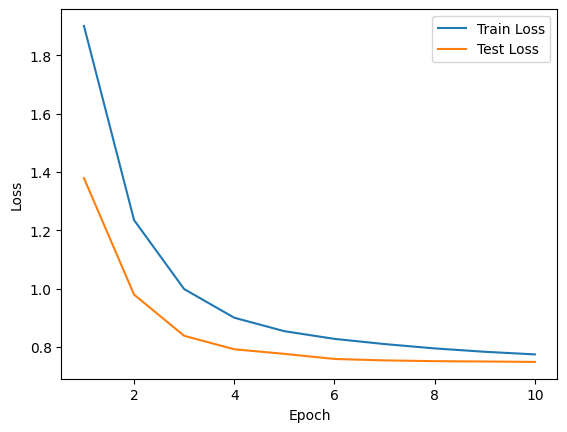

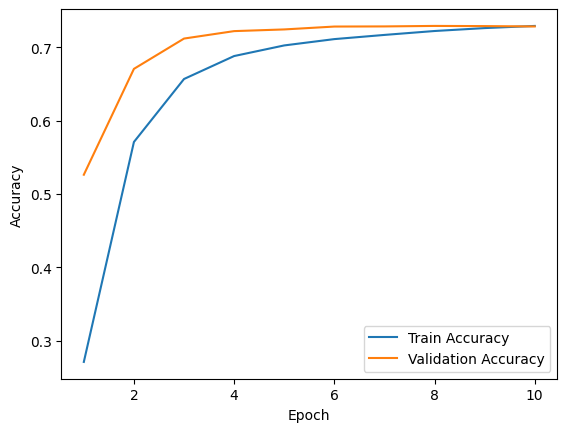

In [100]:
train_model(model, train_loader, val_loader, 10, plots = True)

In [81]:
model

SudokuSolver(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=729, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

*After 9th epoch, for CNN, train accuracy overshoots validation accuracy and it starts overfitting*

#### Model Predictions and Submission File Formatting

In [83]:
def preprocess_puzzle(puzzle_str):
    puzzle_tensor = torch.tensor([int(p) for p in str(puzzle_str)], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    # puzzle = torch.tensor([int(p) for p in str(puzzle_str)], dtype=torch.float32).reshape(1,1, 9, 9)
    # puzzle_normalized = (puzzle - puzzle.min()) / (puzzle.max() - puzzle.min())
    return puzzle_tensor.to(device)

def predict_test_set(model, test_df):
    model.eval()
    predictions = []

    for _, row in test_df.iterrows():
        #print(row)
        puzzle_str = row['partialsudokus']
        with torch.no_grad():
            puzzle_tensor = preprocess_puzzle(puzzle_str)
            output = model(puzzle_tensor)
            solution = output.argmax(dim=1).view(9, 9) + 1  # Convert predictions to 1-based indexing
            predictions.append(solution.cpu().numpy())

    return predictions
predicted_solutions = predict_test_set(model, test_sudokus)

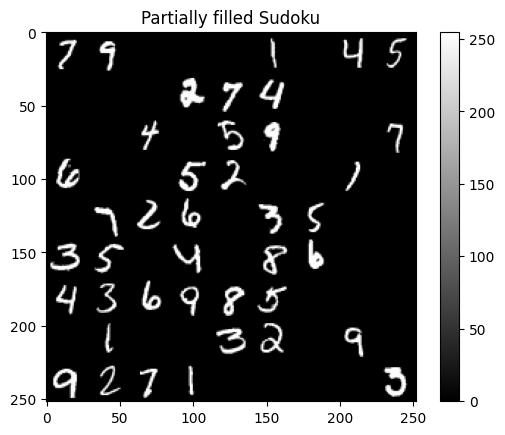

In [84]:
test_images = np.load('./Task2/Test/imgs.npy')
image = test_images[59, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Partially filled Sudoku')
plt.colorbar() 
plt.show()

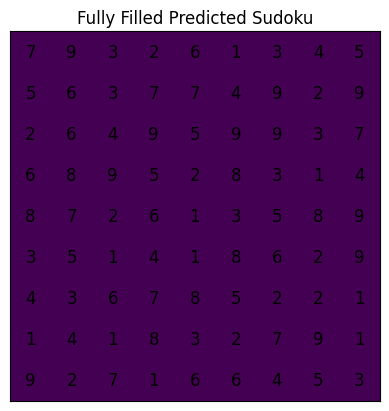

In [85]:
def plot_sudoku_with_numbers(grid):
    fig, ax = plt.subplots()
    ax.matshow(np.zeros_like(grid), cmap='viridis', vmin=0, vmax=9)
    for i in range(9):
        for j in range(9):
            ax.text(j, i, str(grid[i, j]), ha='center', va='center', fontsize=12, color='black')

    plt.xticks([])
    plt.yticks([])
    plt.title('Fully Filled Predicted Sudoku')

# Plot only the first Sudoku grid with numbers
plot_sudoku_with_numbers(predicted_solutions[59])
plt.show()

In [88]:
indexes = []
labels= []
for i,j in enumerate(predicted_solutions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

In [89]:
test_predictions =  {"id":indexes , "values":labels}
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,id,values
0,0_00,4
1,0_01,1
2,0_02,2
3,0_03,7
4,0_04,5
...,...,...
809995,9999_84,8
809996,9999_85,5
809997,9999_86,3
809998,9999_87,9


In [90]:
test_predictions.to_csv("Submission_Task2_CNN.csv", index=False)

### Approach 2 - Using ResNet with MSELoss

#### ResNet Model Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNetSudokuSolver(nn.Module):
    def __init__(self):
        super(ResNetSudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.residual_block1 = ResidualBlock(64, 64)
        self.residual_block2 = ResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 81)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNetSudokuSolver()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
def calculate_accuracy(outputs, labels):
    correct = (outputs == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs, plots):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        # Training Phase
        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            # print('outputs :', outputs.shape)
            # print('sols :', solutions.shape)
            loss = criterion(outputs, solutions.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            train_correct += calculate_accuracy(outputs, solutions) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_accuracy = train_correct / total_train
        train_acc_list.append(train_accuracy)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions).item()
                
                val_correct += calculate_accuracy(outputs, solutions) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_accuracy = val_correct / total_val
        val_acc_list.append(val_accuracy)
        
        #scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
 
    if plots:
        plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_loss_list, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

Epoch 1: Train Loss: 6.9557, Train Accuracy: 0.0000, Validation Loss: 6.0904, Validation Accuracy: 0.0000
Epoch 2: Train Loss: 5.6538, Train Accuracy: 0.0000, Validation Loss: 5.3356, Validation Accuracy: 0.0000
Epoch 3: Train Loss: 4.9840, Train Accuracy: 0.0000, Validation Loss: 4.8447, Validation Accuracy: 0.0000
Epoch 4: Train Loss: 4.5941, Train Accuracy: 0.0000, Validation Loss: 4.6019, Validation Accuracy: 0.0000
Epoch 5: Train Loss: 4.3459, Train Accuracy: 0.0000, Validation Loss: 4.3995, Validation Accuracy: 0.0000
Epoch 6: Train Loss: 4.1533, Train Accuracy: 0.0000, Validation Loss: 4.2556, Validation Accuracy: 0.0000
Epoch 7: Train Loss: 4.0218, Train Accuracy: 0.0000, Validation Loss: 4.1541, Validation Accuracy: 0.0000
Epoch 8: Train Loss: 3.9331, Train Accuracy: 0.0000, Validation Loss: 4.0469, Validation Accuracy: 0.0000
Epoch 9: Train Loss: 3.8669, Train Accuracy: 0.0001, Validation Loss: 4.0089, Validation Accuracy: 0.0000
Epoch 10: Train Loss: 3.8188, Train Accuracy: 

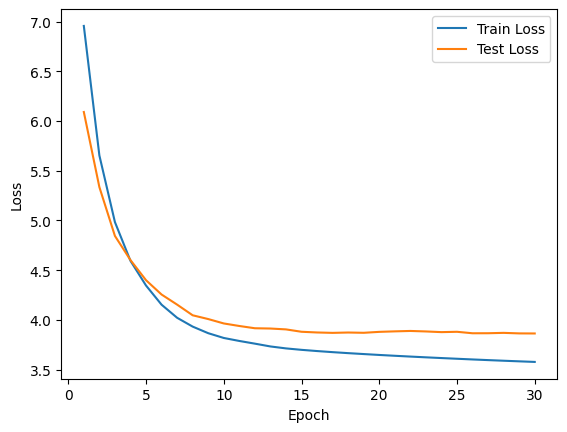

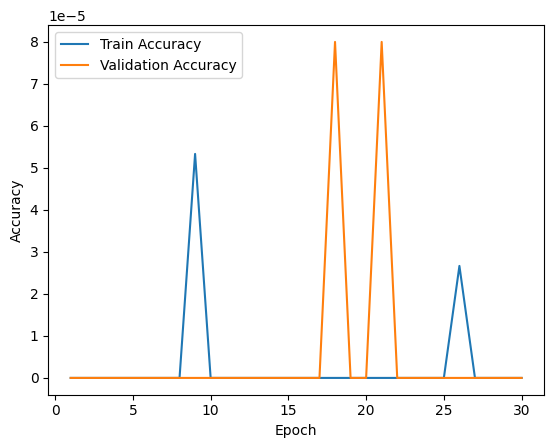

In [ ]:
train_model(model, train_loader, val_loader, 30, plots = True)

In [ ]:
model

ResNetSudokuSolver(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (residual_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential()
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

*MSE loss is not suitable for classification problem*

### Summary
* Identified each digit in sudoku grid with task1 model and concatenated them into strings for both inputs(train and test) and labels into a dataframe
* Normalised each digit in inputs(train and test)
* Using CNN model to learn the sudoku rules from training data with Cross Entropy loss and make predictions for test data
* Using ResNet model to learn the sudoku rules from training data with MSELoss and make predictions for test data
* Converted the test data back into format suitable for submission file

| Task 2     | Model  | Loss  | Accuracy(locally) | Accuracy(kaggle) |
|:--------:|:------:|:----------:|:----------:|:----------:|
| Approach 1     | CNN  | Cross Entropy  |  72% |  73%  |
| Approach 2     | ResNet  | MSELoss  |  1% |   -